In [1]:
import numpy as np
import scipy.stats as scs
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import tushare as ts
%matplotlib inline
np.random.seed(1000)

# Example

In [2]:
def gen_paths(S0, rate, sigma, T, M, I):
    """
    Instructions: Generates Monte Carlo paths for geometric Brownian motion.
    
    Parameters:
        S0: initial stock/index value
        rate: constant short rate
        sigma: constant volatility
        T: final time horizon
        M: number of time steps/intervals
        I: number of paths to be simulated
    
    Return:
        paths: ndarray,shape(M+1,I), simulated paths given the parameters
    """
    dt = float(T) / M
    paths = np.zeros((M + 1, I), np.float64)
    paths[0] = S0
    for t in range(1, M + 1):
        rand = np.random.standard_normal(I)
        rand = (rand - rand.mean()) / rand.std()
        paths[t] = paths[t - 1] * np.exp((rate - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * rand)
    return paths

In [3]:
S0 = 100.
rate = 0.05
sigma = 0.2
T = 1.0
M = 50
I = 250000
paths = gen_paths(S0, rate, sigma, T, M, I)

Text(0, 0.5, 'index level')

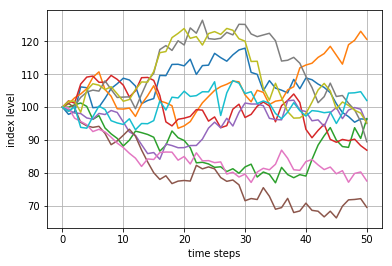

In [4]:
# show the first 10 paths
plt.plot(paths[:, :10])
plt.grid(True)
plt.xlabel('time steps')
plt.ylabel('index level')

In [5]:
# calculate the log return
log_returns = np.log(paths[1:] / paths[:-1])
log_returns[:, 0]

array([-0.02203124,  0.0074989 ,  0.07425871, -0.00241067, -0.05895363,
        0.00178276,  0.02609635,  0.02885558,  0.01359619,  0.01559571,
       -0.00506218, -0.01709255, -0.05161466,  0.00947647,  0.00572308,
        0.06633074, -0.00063321,  0.03059446,  0.00040569, -0.00421005,
        0.01770865, -0.04113215,  0.02412955,  0.00109231,  0.03138786,
       -0.01124531, -0.00948248,  0.01674705,  0.01275389,  0.00465789,
       -0.06449094, -0.00530708, -0.04627662,  0.02884034, -0.02137692,
       -0.00591439, -0.00790518,  0.03862201, -0.0265613 ,  0.03049374,
       -0.00494981, -0.01226703, -0.00942958, -0.01527596, -0.03244427,
       -0.02693745, -0.01271179, -0.01775638,  0.01044232, -0.00091828])

In [6]:
def print_statistics(array):
    sta = scs.describe(array)
    print("%14s %15s" % ('statistic', 'value'))
    print(30 * "-")
    print("%14s %15.5f" % ('size', sta[0]))
    print("%14s %15.5f" % ('min', sta[1][0]))
    print("%14s %15.5f" % ('max', sta[1][1]))
    print("%14s %15.5f" % ('mean', sta[2]))
    print("%14s %15.5f" % ('std', np.sqrt(sta[3])))
    print("%14s %15.5f" % ('skew', sta[4]))
    print("%14s %15.5f" % ('kurtosis', sta[5]))
print_statistics(log_returns.flatten())

     statistic           value
------------------------------
          size  12500000.00000
           min        -0.15664
           max         0.15371
          mean         0.00060
           std         0.02828
          skew         0.00055
      kurtosis         0.00085


## plot the curve

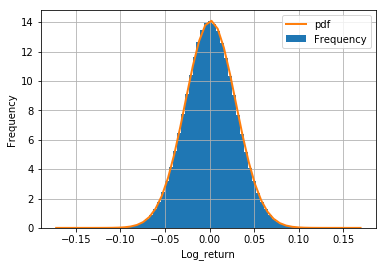

In [7]:
# Compare the log_return distribution and the normal distribution pdf functin
plt.hist(log_returns.flatten(), bins=70, density=True, label='Frequency')
plt.grid(True)
plt.xlabel('Log_return')
plt.ylabel('Frequency')

x = np.linspace(plt.axis()[0], plt.axis()[1])
plt.plot(x, scs.norm.pdf(x, loc=rate/M, scale=sigma /
                         np.sqrt(M)), linewidth=2.0, label='pdf')
plt.legend(loc='best')

Text(0, 0.5, 'sample quantiles')

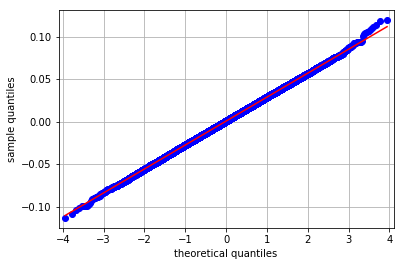

In [8]:
# QQplot
sm.qqplot(log_returns.flatten()[::500], line='s')
plt.grid(True)
plt.xlabel('theoretical quantiles')
plt.ylabel('sample quantiles')

## The statistical test

In [9]:
def normality_tests(arr):
    """
    Tests for normality distribution of given data set
    :param arr: ndarray
    object to generate statistics on
    :return:
    """
    print("Skew of data set  %14.3f" % scs.skew(arr))
    print("Skew test p-value %14.3f" % scs.skewtest(arr)[1])
    print("Kurt of data set  %14.3f" % scs.kurtosis(arr))
    print("Kurt test p-value %14.3f" % scs.kurtosistest(arr)[1])
    print("Normality test p-value %14.3f" % scs.normaltest(arr)[1])
normality_tests(log_returns.flatten())

Skew of data set           0.001
Skew test p-value          0.430
Kurt of data set           0.001
Kurt test p-value          0.541
Normality test p-value          0.607


# The real stock data

In [10]:
symbols = ['sh000001', '399001', '600118', '000519']
indexes = pd.date_range('2016-01-01', '2018-07-06')
# change the date index into string type
indexes = indexes.map(lambda x: datetime.datetime.strftime(x, '%Y-%m-%d'))
df = pd.DataFrame(index=indexes)
for sym in symbols:
    k_d = ts.get_k_data(sym, start='2016-01-01',ktype='D')
#     k_d['date'] = k_d['date'].astype('datetime64[ns]')
    k_d.set_index('date', inplace=True)
    # get the close price of each symbols
    df[sym] = k_d['close']
# drop the nan value from the different date index
df = df.dropna()
print(df.head())
print(df.info())

            sh000001    399001  600118  000519
2016-01-04   3296.66  11630.93  38.935   16.16
2016-01-05   3287.71  11468.06  39.843   17.45
2016-01-06   3361.84  11724.88  40.702   19.20
2016-01-07   3125.00  10760.27  36.823   17.28
2016-01-08   3186.41  10888.91  36.044   17.24
<class 'pandas.core.frame.DataFrame'>
Index: 605 entries, 2016-01-04 to 2018-07-06
Data columns (total 4 columns):
sh000001    605 non-null float64
399001      605 non-null float64
600118      605 non-null float64
000519      605 non-null float64
dtypes: float64(4)
memory usage: 23.6+ KB
None


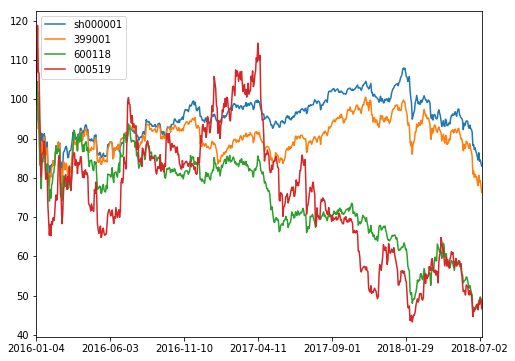

In [11]:
(df / df.iloc[0] * 100).plot(figsize=(8,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E903242080>,
      dtype=object)

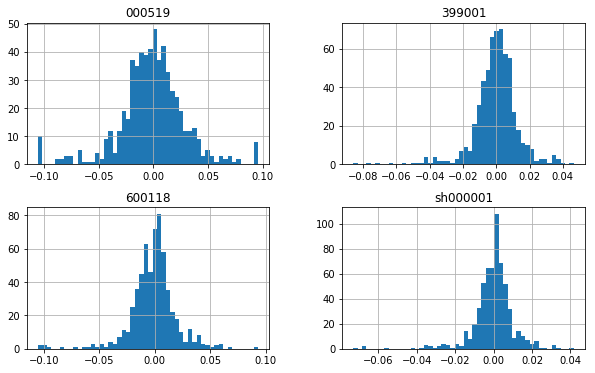

In [12]:
log_return = np.log(df / df.shift(1)[1:])
log_return.hist(bins=50, figsize=(10,6))

In [13]:
for sym in symbols:
    print("\nResults for symbol %s" % sym)
    print(30 * "-")
    log_data = np.array(log_return[sym].dropna())
    print_statistics(log_data)


Results for symbol sh000001
------------------------------
     statistic           value
------------------------------
          size       604.00000
           min        -0.07305
           max         0.04174
          mean        -0.00030
           std         0.01077
          skew        -1.65159
      kurtosis         9.99414

Results for symbol 399001
------------------------------
     statistic           value
------------------------------
          size       604.00000
           min        -0.08585
           max         0.04657
          mean        -0.00044
           std         0.01390
          skew        -1.29898
      kurtosis         6.60328

Results for symbol 600118
------------------------------
     statistic           value
------------------------------
          size       604.00000
           min        -0.10545
           max         0.09333
          mean        -0.00120
           std         0.02069
          skew        -0.75624
      kurtosis    

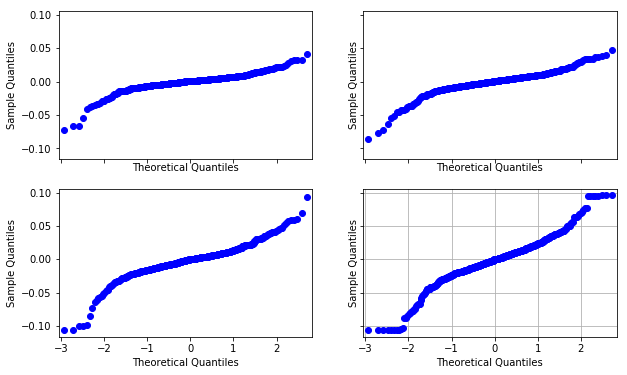

In [14]:
#  qqplot to show the norality
fig, ax = plt.subplots(2, 2, sharex=True,sharey=True, figsize=(10,6))
for i, sym in enumerate(symbols):
    sm.qqplot(log_return[sym].values,ax=ax[i//2, i-i//2*2], line='s')
    plt.grid(True)

In [15]:
# Using the statistical test
for sym in symbols:
    print("\nResults for symbol %s" % sym)
    print(30 * "-")
    log_data = np.array(log_return[sym].dropna())
    normality_tests(log_data)


Results for symbol sh000001
------------------------------
Skew of data set          -1.652
Skew test p-value          0.000
Kurt of data set           9.994
Kurt test p-value          0.000
Normality test p-value          0.000

Results for symbol 399001
------------------------------
Skew of data set          -1.299
Skew test p-value          0.000
Kurt of data set           6.603
Kurt test p-value          0.000
Normality test p-value          0.000

Results for symbol 600118
------------------------------
Skew of data set          -0.756
Skew test p-value          0.000
Kurt of data set           5.640
Kurt test p-value          0.000
Normality test p-value          0.000

Results for symbol 000519
------------------------------
Skew of data set          -0.309
Skew test p-value          0.002
Kurt of data set           2.342
Kurt test p-value          0.000
Normality test p-value          0.000


Throughout, the p-values for the different tests were zero, strongly rejecting the test hypothesis that the different sample data sets were normally distributed.This shows that the normal assumptions of stock market returns -- such as those in the geometric Brownian motion model -- cannot usually be proved to be correct, and richer models that generate "big tails" may be needed